In [127]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv


In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow import keras
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.activations import selu

# Importing data

<h2>Loading data</h2>

We will first proceed to import the csv training and testing data into their respective dataframes using `read_csv`

In [129]:
df_train = pd.read_csv('../input/digit-recognizer/train.csv')
df_test = pd.read_csv('../input/digit-recognizer/test.csv')

In [130]:
print(df_train.shape)
print(df_test.shape)

(42000, 785)
(28000, 784)


In [131]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [132]:
df_train.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

We have a total of 784 pixels (28 x 28) and the label column which corresponds to the digit the image signifies

In [133]:
df_train['label'].unique()

array([1, 0, 4, 7, 3, 5, 8, 9, 2, 6])

In [134]:
df_train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


We see that the pixels are divided in the value range of 0-255 which is the norm for grayscale images.

In [135]:
y_train = df_train['label']
x_train = df_train.drop(['label'],axis=1)

Text(0.5, 1.0, 'Frequency of each digit in the training set')

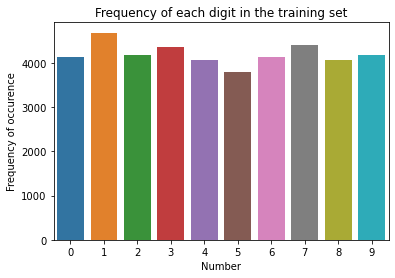

In [136]:
g = sns.countplot(x=y_train)
g.set_ylabel('Frequency of occurence')
g.set_xlabel('Number')
g.set_title('Frequency of each digit in the training set')

We see that the dataset does not suffer from any form of imbalance. Each number has adequate training cases.

# NULL values

In [137]:
#Using the general format of testing for NULL values
x_train.isnull().sum()

pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 784, dtype: int64

We see that we have too many columns to comfortably display the NULL value sum in each column, therefore we will use list comprehensions

In [138]:
#Checking presence of NULL values in the training set:
nan_cols = [i for i in x_train.columns if x_train[i].isnull().any()]
nan_cols

[]

In [139]:
#Checking presence of NULL values in the test set
nan_test = [i for i in df_test.columns if df_test[i].isnull().any()]
nan_test

[]

Therefore, we see that none of the columns containing any NULL values, therefore we can continue accordingly.

# Normalizing

We can normalize the dataset to have values in the range (0-1) by diving all values by 255.0

In [140]:
#Divide by float to preserve fractional component

x_train = x_train/255.0 
df_test = df_test/255.0

# Reshaping data

We proceed to reshape the data in a correct format for our convolutional network to process: (Batch size, height, width, channels)

Here the channel would be 1 as we are dealing with grayscale images, unlike RGB where we would have it as 3

In [141]:
x_train = x_train.values.reshape(-1,28,28,1)
df_test = df_test.values.reshape(-1,28,28,1)

In [142]:
print(x_train.shape)
print(df_test.shape)

(42000, 28, 28, 1)
(28000, 28, 28, 1)


# Viewing example images

We can visualize these images using matplotlib

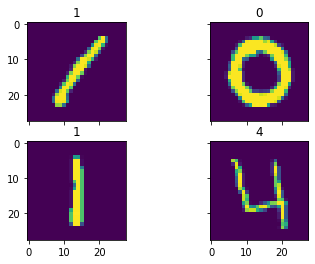

In [143]:
n_rows = 2
n_cols = 2 
c = 0
fig, ax = plt.subplots(n_rows,n_cols,sharex=True,sharey=True)
for i in range(0,n_rows):
    for j in range (0,n_cols):
        ax[i,j].imshow(x_train[c][:,:,0])
        ax[i,j].set_title(y_train[c])
        c=c+1

# One hot encoding 

We will encode the labels in the dataset to one-hot vectors

In [144]:
#We have 10 classes (0-9)
y_train = to_categorical(y_train,num_classes=10) #Will convert values like 1 to [0 1 0 0 0 0 0 0 0 0 ]

In [145]:
rand = 0

In [146]:
#Split the training into training and validation dataset for our CNN

x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.1,random_state=rand)

In [147]:
model = Sequential()
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='Same',activation='selu',kernel_initializer='lecun_normal'))
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='Same',activation='selu',kernel_initializer='lecun_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='Same',activation='selu',kernel_initializer='lecun_normal'))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='Same',activation='selu',kernel_initializer='lecun_normal'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dense(10, activation = "softmax"))

In [148]:
model.compile(optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0), loss = "categorical_crossentropy", metrics=["accuracy"])

We achieve a very high validation accuracy (0.9883), we can further improve this by introducing data augmentation as well as some learning rate scheduling.

We will introduce horizontal shifts, vertical shifts and zoomed training data in the dataset

In [149]:
img_gen = ImageDataGenerator(
    featurewise_center=False, 
    samplewise_center=False,
    featurewise_std_normalization=False, 
    samplewise_std_normalization=False,
    rotation_range=10, 
    width_shift_range=0.1,
    height_shift_range=0.1, 
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
)

img_gen.fit(x_train)

We cannot incorporate horizontal and vertical flips as for cases with 6 and 9, it may hurt the dataset's training.

This above function will introduce the following operations:

* Randomly rotate some images by 10 degrees
* Randomly zoom 10% training images
* Randomly shift training images 10% horizontally and vertically

In [150]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=0, mode='auto',min_delta=0.0001, cooldown=0, min_lr=0.00001)
eas_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto',baseline=None, restore_best_weights=True)

In [151]:
n_epochs = 30
history = model.fit_generator(img_gen.flow(x_train, y_train),epochs=n_epochs,validation_data=(x_val, y_val),callbacks=[reduce_lr])

Epoch 1/30
1182/1182 [==============================] - 146s 123ms/step - loss: 0.3497 - accuracy: 0.9072 - val_loss: 0.1215 - val_accuracy: 0.9676 - lr: 0.0010
Epoch 2/30
1182/1182 [==============================] - 149s 126ms/step - loss: 0.1719 - accuracy: 0.9593 - val_loss: 0.1391 - val_accuracy: 0.9664 - lr: 0.0010
Epoch 3/30
1182/1182 [==============================] - 149s 126ms/step - loss: 0.1692 - accuracy: 0.9655 - val_loss: 0.0832 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 4/30
1182/1182 [==============================] - 145s 122ms/step - loss: 0.1608 - accuracy: 0.9686 - val_loss: 0.1504 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 5/30
1182/1182 [==============================] - 145s 123ms/step - loss: 0.1706 - accuracy: 0.9691 - val_loss: 0.1014 - val_accuracy: 0.9817 - lr: 0.0010
Epoch 6/30
1182/1182 [==============================] - 144s 122ms/step - loss: 0.1726 - accuracy: 0.9714 - val_loss: 0.1405 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 7/30
1182/1182 [============

# Confusion matrix

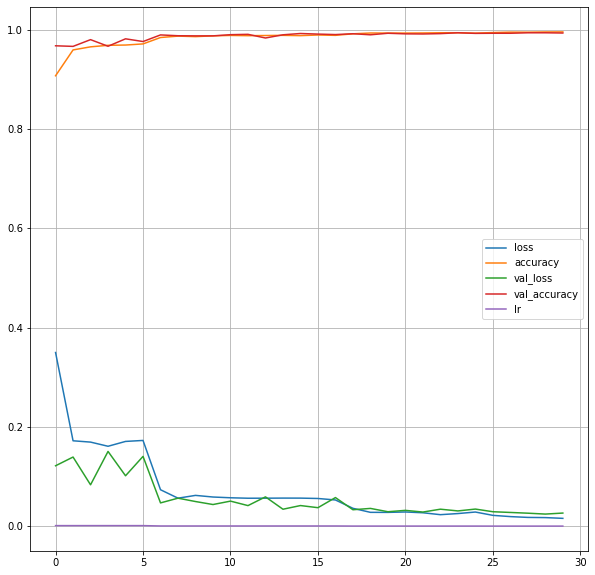

In [152]:
#Final optimisations of the model:
pd.DataFrame(history.history).plot(figsize=(10,10))
plt.grid(True)
plt.show()

In [153]:
yp = model.predict(x_val)

In [154]:
yp.shape

(4200, 10)

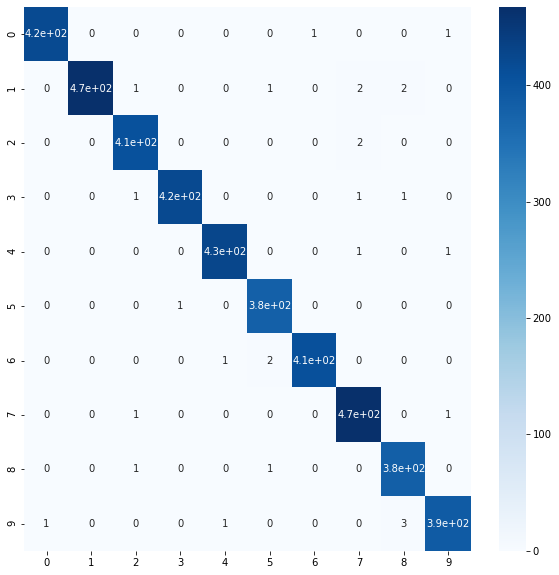

In [155]:
y_class = np.argmax(yp,axis = 1) 
y = np.argmax(y_val,axis = 1) 
plt.figure(figsize=(10,10))
confusion_mtx = confusion_matrix(y, y_class) 
sns.heatmap(confusion_mtx,annot=True,cmap='Blues')

Here, we see that we are able to get most of the predictions right except a few of them still left as wrongly labelled

# Checking for errors

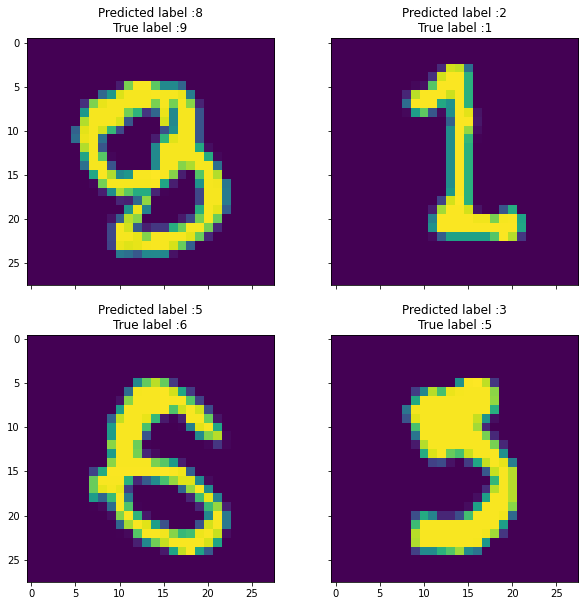

In [156]:
error = (y_class - y)!=0
y_class_error = y_class[error]
y_error = y[error]
x_val_error = x_val[error]
n_rows = 2
n_cols = 2
c=0
fig, ax = plt.subplots(n_rows,n_cols,sharex=True,sharey=True,figsize=(10,10))
for i in range(0,n_rows):
    for j in range(0,n_cols):
        ax[i,j].imshow((x_val_error[c]).reshape((28,28)))
        ax[i,j].set_title(("Predicted label :{}\nTrue label :{}".format(y_class_error[c],y_error[c])))
        c=c+1
    

In [157]:
# predict results
results = model.predict(df_test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)

In [1]:
history = model.fit_generator(img_gen.flow(x_train, y_train),epochs=10,validation_data=(x_val, y_val),callbacks=[reduce_lr])

NameError: name 'model' is not defined